In [25]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics

from src.edit_distance_feature import edit_distance_feature

# TODO reorder this

# Predicting failing tests

After having a look at the data (and we will continue to do that), the question is if we can train machine learning models to predict failing tests.
While this has obious applications in test selection and reordering, we might also be able to see hidden dependencies between tests, if models show interesting behaviours on the different datasets.

To be able to answer these questions, we first have to bring the data into an appropriate from, encoding string values, etc.

In [37]:
# Load datasets
def load_dataset(filename, sparsify=False):
    mutants_and_tests = pd.read_pickle(filename)
    mutants_and_tests.reset_index()
    mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
    mutants_and_tests["outcome"]
    #display(mutants_and_tests)
    if sparsify:
        keep_fraction = 0.1 # Keep 10% of the dataset (roughly, since we delete tests and mutants smaller than that)
        max_mutant_id = mutants_and_tests['mutant_id'].max()
        max_test_id = mutants_and_tests['test_id'].max()
        return mutants_and_tests.loc[mutants_and_tests['test_id'] < max_test_id * keep_fraction].loc[mutants_and_tests['mutant_id'] < max_mutant_id * keep_fraction]
    return mutants_and_tests

datasets = {}
for name, filename in {'Flask': 'flask_full.pkl', 'Jinja': 'jinja_full.pkl', 'Httpie': 'httpie_full.pkl', 'Docopt': 'docopt_full.pkl'}.items():
    # It is possible to use the sparsify flag, if you want to test if models throw errors / for a quick check.
    # USE WITH CAUTION: This is by no means designed to give an appropriate / random sample.
    dataset = load_dataset('data/' + filename, sparsify=False) 
    datasets[name] = dataset

# Data Preparation

### Cleansing

In [38]:
def cleanse_data(mutants_and_tests):
    # Encode None as false in the context
    for column in ["contains_branch_mutant", "contains_loop_mutant", "contains_math_operands_mutant", "contains_equality_comparison_mutant",
                   "contains_branch_execution", "contains_loop_execution", "contains_math_operands_execution", "contains_equality_comparison_execution",
                    "teardown_outcome", "setup_outcome", "call_outcome", "outcome"]:
        mutants_and_tests.loc[mutants_and_tests[column].isnull(), column] = False

    #Encode NaN as 0 in the duration stuff
    for column in ["teardown_duration", "setup_duration", "call_duration"]:
        mutants_and_tests.loc[pd.isnull(mutants_and_tests[column]), column] = 0
        
for mutants_and_tests in datasets.values(): # TODO: Can possibly be merged to preprocessing steps
    cleanse_data(mutants_and_tests)

In [39]:
# Sometimes, test_ids only occur very rarely and make problems in the reordering. They can be removed here from the dataset
test_ids_to_kill = [] # e.g.: [82, 83]
for test_id in test_ids_to_kill:
    mutants_and_tests = mutants_and_tests.loc[mutants_and_tests['test_id'] != test_id]
mutants_and_tests = mutants_and_tests.copy()

### Feature Generation and Encoding

In [40]:
def add_edit_distance_feature(mutants_and_tests):
    # Fix object and fill null values
    mutants_and_tests["name"] = mutants_and_tests["name"].astype('string')
    mutants_and_tests["modified_method"] = mutants_and_tests["modified_method"].astype('string')

    mutants_and_tests["name"].loc[pd.isnull(mutants_and_tests["name"])] = ""
    mutants_and_tests["modified_method"].loc[pd.isnull(mutants_and_tests["modified_method"])] = ""

    mutants_and_tests['edit_distance'] = edit_distance_feature(
        mutants_and_tests['modified_method'],
        mutants_and_tests['name']
    )
    mutants_and_tests['edit_distance'].value_counts()

def encode_columns(column):
    enc = OrdinalEncoder()
    X_enc = enc.fit_transform(X[columns])
    i = 0
    for column_name in columns:
        X[column_name] = X_enc[:,i]
        i += 1

columns = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
encoded_datasets = {}
for name, mutants_and_tests in datasets.items():
    add_edit_distance_feature(mutants_and_tests)
    encoded_datasets[name] = encode_columns(columns)

for mutants_and_tests in datasets.values():
    add_edit_distance_feature(mutants_and_tests)

The method_name feature seems to make sense from a human perspective: If I change code in the same method, I would expect similar tests to fail.
But to go even further, I tried to add a numerical value, the edit distance between the test name and the method name. The expectation here was, that when both are similar, the test is more likely to fail. You can see examples for that in the presentation slides, page ... (TODO: LINK THAT)

In the ROC Curve, we can see that if we use the edit_distance as a standalone feature, Httpie and Flask behave better than Jinja and Docopt.
This is interesting, since we have previously seen that both of these projects also had a better distinsting between 'Unit Tests' that test a very specific part of the code, and very few integration tests.

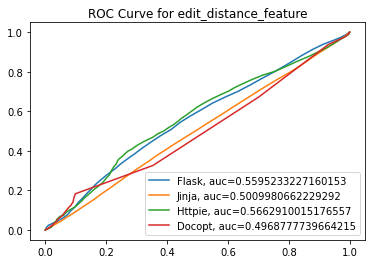

In [41]:
def plot_edit_distance_roc_curve(datasets):
    for name, mutants_and_tests in datasets.items():
        fpr, tpr, thresholds = metrics.roc_curve(mutants_and_tests['outcome'], mutants_and_tests['edit_distance'])
        auc = metrics.roc_auc_score(mutants_and_tests['outcome'], mutants_and_tests['edit_distance'])
        plt.plot(fpr,tpr,label=name + ", auc="+str(auc))
    plt.legend(loc=4)
    plt.title("ROC Curve for edit_distance feature")
    plt.show()

    
plot_edit_distance_roc_curve(datasets)

In [14]:
# Now create X and y, since we will encode columns in X and want to keep them in mutants_and_tests
X = mutants_and_tests.drop(['outcome'], axis=1)
y = mutants_and_tests["outcome"]

# Throw out nan values:
previous_length = len(X)
X = X.loc[mutants_and_tests.isnull().any(axis=1) == False]
y = mutants_and_tests["outcome"].loc[mutants_and_tests.isnull().any(axis=1) == False]
print("Kicked out " + str(previous_length - len(X)) + " values from " + str(previous_length) + " total values. (" + str((1 - len(X) / previous_length) * 100) + "%)")

Kicked out 0 values from 946 total values. (0.0%)


In [32]:
# Baseline: Search for the mutant with the smallest distance, and predict the same values


print(y_train.value_counts())
print(y_test.value_counts())

predictions = []

for index, row in X_test.iterrows():
    
    # Select only rows from X_train with the same test_id
    correct_tests = X_train.loc[X_train['test_id'] == row['test_id']]
    #print("Test_id: " + str(row['test_id']))
    #print("Mutant_id: " + str(row['mutant_id']))
    #print(len(correct_tests))
    mutant_id = row['mutant_id']
    #print(correct_tests)
    nearest_mutant_id_index = abs(correct_tests['mutant_id'] - mutant_id).idxmin()
    #print(nearest_mutant_id_index)
    #print(y_train)
    predictions.append(y_train[nearest_mutant_id_index])



print(index)

print(len(predictions))

print(classification_report(y_test, predictions))

True     573303
False     43155
Name: outcome, dtype: int64
True     265942
False     37688
Name: outcome, dtype: int64
958040
303630
              precision    recall  f1-score   support

       False       0.66      0.29      0.40     37688
        True       0.91      0.98      0.94    265942

    accuracy                           0.89    303630
   macro avg       0.78      0.63      0.67    303630
weighted avg       0.88      0.89      0.87    303630



In [18]:
y_test

650645    True
650646    True
650647    True
650648    True
650649    True
          ... 
958036    True
958037    True
958038    True
958039    True
958040    True
Name: outcome, Length: 303630, dtype: bool